# HW 3 - Blood Drive Simulation
In this notebook, we will be exploring and simulating the process of donating blood. I choose to pick this type of model is because I recently donated some blood at a blood drive.

## Preliminaries

In [10]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Import commonly used libraries and magic command for inline plotting

In [1]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

In [3]:
%matplotlib inline

# Model

Here is the basic model of what the blood donation would look like.

    Arrival --> Registration/Questionare Form --> Medical Screening --> Mini Physical --> Blood Donation --> Post drawn blood observation --> Refreshment station --> Exit

In this model we want to consider a couple of things:
* How long it may take overall with the number of workers present at specific stations?
* At what point does the model start to bottle neck?
* If there is anyway we can keep the rate constant without long lag times in the flow.

## Generating blood drive donors 

Let's first start with the creation of the donors for our blood drive. We want to make there arrival time random to demonstrate a Poisson arrival.

In [44]:
from numpy.random import default_rng
rg = default_rng(seed=4470)
print(rg.random())
print(rg.random())

0.45855804438027437
0.15021752731855942


In [46]:
def donor_rand_arrivals(env, interarrival_time=0, rg=default_rng(0)):
    """Generating blood donors according to a Poisson arrival process"""

    # Creation of counter to keep track of the number of donors generated and there unique id
    donor = 0

    # Infinite loop for generating donors
    while True:

        # Generate next interarrival time from exponential distribution
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # update counter of donor
        donor += 1
        
        print(f"Donor {donor} created at time {env.now}")



In [48]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts the patient_arrivals process and adds it to the environment
runtime = 100
interarrival_time = 5.0
env1.process(donor_rand_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

Donor 1 created at time 3.3996595198445476
Donor 2 created at time 8.49764502717387
Donor 3 created at time 8.596678340119148
Donor 4 created at time 8.60802497352529
Donor 5 created at time 11.35973933672053
Donor 6 created at time 19.509441510012458
Donor 7 created at time 22.877356273348617
Donor 8 created at time 26.653863062475573
Donor 9 created at time 40.7377929578542
Donor 10 created at time 71.02655836006706
Donor 11 created at time 87.45869964953577
Donor 12 created at time 87.46513840120988
Donor 13 created at time 98.81061172254442
Donor 14 created at time 99.17310014714388


In [50]:
# Import exponential distribution function from scipy.stats
from scipy.stats import expon
# Set mean of this distribution to whatever we were using above for interarrival time
mean_interarrival_time = interarrival_time
# Create a random variable object based on the exponential distribution with the given mean
rv_expon = expon(scale=mean_interarrival_time)

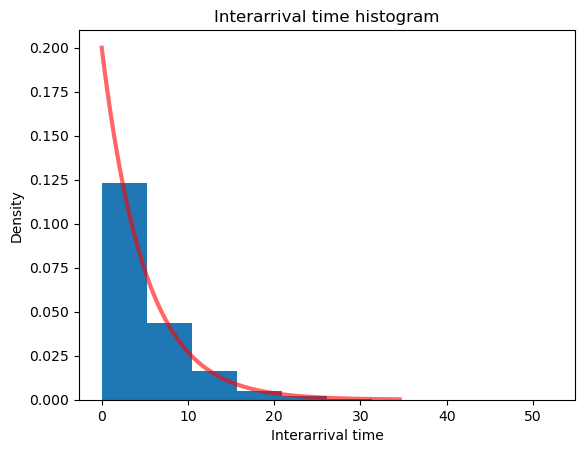

In [52]:
# Generate 1000 exponential random variates (notice this is the exponential function from numpy)
iat_sample = rg.exponential(mean_interarrival_time, 10000)

# Create a histogram of the random samples with exponential pdf overlaid
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(iat_sample, density=True);

# Create values for the x-axis using expon function from SciPy
x_expon = np.linspace(rv_expon.ppf(0.0001),
                rv_expon.ppf(0.999), 500)

# Create values for the y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf,
       'r-', lw=3, alpha=0.6, label='Exponential pdf');



## Beginning of donation process

In this part of the model, let's focus on the necessary steps that donors will have to do in order to complete and procede to the drawing blood phase.

In [57]:
class BloodDonationDrive(object):
    def __init__(self, env, num_screening_nurse, num_of_donors, num_physical_dr, num_blood_nurse, num_post_obs_staff, rg):
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # Create list to hold timestamps dictionaries (one per donor)
        self.timestamps_list = []
        # Create lists to hold occupancy tuples (time, occ)
        self.postdonation_occupancy_list = [(0.0, 0.0)]
        self.donor_occupancy_list = [(0.0, 0.0)]
        
        # Create resources
        self.screening_nurse = simpy.Resource(env, num_screening_nurse)
        self.donors = simpy.Resource(env, num_of_donors)
        self.physical_dr = simpy.Resource(env, num_physical_dr)
        self.blood_nurse = simpy.Resource(env, num_blood_nurse)
        self.post_obs_staff = simpy.Resource(env, num_post_obs_staff)


    # Create process methods - hard coding processing time distributions for now
    # TODO - remove hard coding
    # The patient argument is just a unique integer number
    def registration(self, donor):
        yield self.env.timeout(self.rg.exponential(1.0))
    
    def medical_screening(self, donor):
        yield self.env.timeout(self.rg.normal(0.25, 0.05))

    def mini_physical(self, donor):
        yield self.env.timeout(self.rg.normal(0.25, 0.05))

    def blood_donation(self, donor):
        yield self.env.timeout(self.rg.normal(4.0, 0.5))
        
    # We assume all patients wait at least 15 minutes post-vaccination
    # Some will choose to wait longer. This is the time beyond 15 minutes
    # that patients wait.
    def wait_time_refreshments(self, donor):
        yield self.env.timeout(self.rg.exponential(0.5))

In [ ]:
def drawing_blood(env, donor, clinic, pct_first_dose, rg):
    # Patient arrives to clinic - note the arrival time
    arrival_ts = env.now

    # Request a greeter for temperature check
    # By using request() in a context manager, we'll automatically release the resource when done
    with clinic.greeter.request() as request:
        yield request
        # Now that we have a greeter, check temperature. Note time.
        got_greeter_ts = env.now
        yield env.process(clinic.temperature_check(patient))
        release_greeter_ts = env.now

    # Request reg staff to get registered
    with clinic.reg_staff.request() as request:
        yield request
        got_reg_ts = env.now
        yield env.process(clinic.registration(patient))
        release_reg_ts = env.now
        
    # Request clinical staff to get vaccinated
    with clinic.vaccinator.request() as request:
        yield request
        got_vaccinator_ts = env.now
        # Update vac occupancy - increment by 1
        prev_occ = clinic.vac_occupancy_list[-1][1]
        new_occ = (env.now, prev_occ + 1)
        clinic.vac_occupancy_list.append(new_occ)
        yield env.process(clinic.vaccinate(patient))
        release_vaccinator_ts = env.now
        # Update vac occupancy - decrement by 1 - more compact code
        # Note that clinic.vac_occupancy_list[-1] is the last tuple in the list
        #  and that clinic.vac_occupancy_list[-1][1] is referencing the occupancy
        #  value in the tuple (remember tuple elements are indexed starting with 0, so
        #  the timestamp is at [0] and the occupancy is at [1]).
        #  BTW, this suggests that perhaps using something known as "namedtuples" might
        #  make our code more readable. See https://realpython.com/python-namedtuple/ 
        #  for a good introduction to namedtuples.
        clinic.vac_occupancy_list.append((env.now, clinic.vac_occupancy_list[-1][1] - 1))
        
        # Update postvac occupancy - increment by 1
        clinic.postvac_occupancy_list.append((env.now, clinic.postvac_occupancy_list[-1][1] + 1))

    # Request scheduler to schedule second dose if needed
    if rg.random() < pct_first_dose:
        with clinic.scheduler.request() as request:
            yield request
            got_scheduler_ts = env.now
            yield env.process(clinic.schedule_dose_2(patient))
            release_scheduler_ts = env.now
    else:
        got_scheduler_ts = pd.NA
        release_scheduler_ts = pd.NA
        
    # Wait at least 15 minutes from time we finished getting vaccinated 
    post_vac_time = env.now - release_vaccinator_ts
    if post_vac_time < 15:
        # Wait until 15 total minutes post vac
        yield env.timeout(15 - post_vac_time)
        # Wait random amount beyond 15 minutes
        yield env.process(clinic.wait_gt_15(patient))
        exit_system_ts = env.now
        
        # Update postvac occupancy - decrement by 1
        clinic.postvac_occupancy_list.append((env.now, clinic.postvac_occupancy_list[-1][1] - 1))
    
    exit_system_ts = env.now    
    #print(f"Patient {patient} exited at time {env.now}")

    # Create dictionary of timestamps
    timestamps = {'patient_id': patient,
                  'arrival_ts': arrival_ts,
                  'got_greeter_ts': got_greeter_ts,
                  'release_greeter_ts': release_greeter_ts,
                  'got_reg_ts': got_reg_ts,
                  'release_reg_ts': release_reg_ts,
                  'got_vaccinator_ts': got_vaccinator_ts,
                  'release_vaccinator_ts': release_vaccinator_ts,
                  'got_scheduler_ts': got_scheduler_ts,
                  'release_scheduler_ts': release_scheduler_ts,
                  'exit_system_ts': exit_system_ts}
    
    clinic.timestamps_list.append(timestamps)